<center><h1>Modèle RNN - CTCLoss</h1></center>

In [ ]:
#Traitement des mots ou des lignes
data = "words"#"lines"
#Entraînement du modèle (train=True) ou chargement des poids (Train=False):
train = False

>> I - [Importation des données](#preparation)
>>
>>II - [Prétraitement des données](#pretraitement)
>>
>>III - [Définition du modèle](#model)
>>
>>IV - [Entraînement du modèle](#train)
>>
>>V - [Chargement des poids du modèle](#weights)
>>
>>VI - [Prédictions](#prediction)

- Importation des fichiers et des modules nécessaires.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir database
! mkdir database/ascii
! tar xzf drive/MyDrive/ocr/database/ascii.tgz -C database/ascii

! mkdir database/words
! tar xzf drive/MyDrive/ocr/database/words.tgz -C database/words
! mkdir database/lines
! tar xzf drive/MyDrive/ocr/database/lines.tgz -C database/lines
! mkdir database/images_test
! cp -r drive/MyDrive/ocr/database/images_test/* database/images_test/

! cp drive/MyDrive/ocr/src/importation.py importation.py
! cp drive/MyDrive/ocr/src/preprocessor.py preprocessor.py

! mkdir models
! cp drive/MyDrive/ocr/models/* models/

In [ ]:
from importation import Importation
from preprocessor import Preprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from datetime import datetime
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, Dense, Dropout, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM

# I - <a name="preparation"></a> Importation des données

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)


imp = Importation('database')

if data=="words":
    image_width = 128
    image_height = 32
    df = imp.get_words().sample(frac=1, random_state=1).reset_index()
    

if data=="lines":
    image_width = 400
    image_height = 32
    df = imp.get_lines().sample(frac=1, random_state=1).reset_index()
  
df = df[["file", "label"]]
img_size = (image_width, image_height)   
# ensemble des caractères utilisés et taille du plus long mot
max_len, longest_word, characters = imp.get_characters(df.label)
vocab_size = len(characters)

print(f"Nombre d'images à disposition: {len(df)}\n")
if data=="words":
    print(f"Mot le plus long: '{longest_word}', {max_len} caractères\n")
if data=="lines":
    print(f"Ligne la plus longue: '{longest_word}', {max_len} caractères\n")
print(f"Vocabulaire : {vocab_size} caractères \n {sorted(characters)}")

df.head()

Nombre d'images à disposition: 96454

Mot le plus long: 'middle-income-bracket', 21 caractères

Vocabulaire : 79 caractères 
 [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


,file,label
0,database/words/a05/a05-022/a05-022-07-06.png,aspect
1,database/words/c04/c04-105/c04-105-00-02.png,on
2,database/words/a03/a03-017/a03-017-03-03.png,only
3,database/words/p06/p06-052/p06-052-02-05.png,speak
4,database/words/g06/g06-018h/g06-018h-06-09.png,of


# II - <a name="preparation"></a> Prétraitement des données

In [ ]:
batch_size = 64

prepro = Preprocess(img_size, batch_size=batch_size, gaussianBlur=True, max_len=max_len, characters=characters)

# Split des données en un ensemble d'entraînement (90% des données), un ensemble de validation (5%) 
# et un ensemble de test (5%)
df_train, df_valid, df_test = prepro.split_data(df, train_size=0.9)
    
x_train, y_train = df_train["file"].values, df_train["label"].values
x_test, y_test = df_test["file"].values, df_test["label"].values
x_valid, y_valid  = df_valid["file"].values, df_valid["label"].values

# Création des datasets
# redimensionnement des images sans déformation et application d'un filtre gaussian blur
# vectorisation des labels et uniformisation de la longueur :
# vecteur de dimension de la taille du plus long mot (max_len) - token pour compléter : 99


train_ds = prepro.prepare_dataset(x_train, y_train)
validation_ds = prepro.prepare_dataset(x_valid, y_valid)
test_ds = prepro.prepare_dataset(x_test, y_test)

# ensemble de validation pour le calcul de l'edit distance pendant l'entrainement du modèle
if train:
  validation_images, validation_labels = prepro.get_images_labels(validation_ds)

## II.1 - <a name="exemple1"></a> Exemple d'images traitées

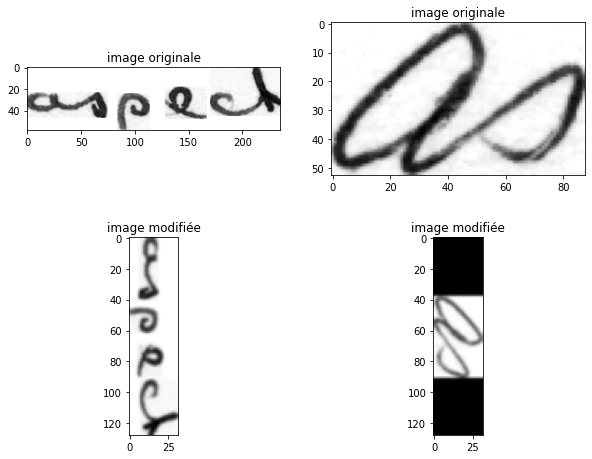

In [ ]:
def traitement_image(image):
  image0 = tf.io.read_file(image)
  image0 = tf.image.decode_png(image0, 1)
  #redimensionnement
  image = prepro.distortion_free_resize(image0, image_height, image_width)
  image = tf.cast(image, tf.float32) / 255.0
  # application filtre
  image = cv2.GaussianBlur(np.squeeze(image.numpy()),(3,3),0)
  return tf.squeeze(image0), image


image1, image1_traitee = traitement_image(x_train[0])
image2, image2_traitee = traitement_image(x_train[27])

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.title('image originale')
plt.imshow(image1,cmap='gray')
plt.subplot(2,2,3)
plt.title('image modifiée')
plt.imshow(image1_traitee,cmap='gray')
plt.subplot(2,2,2)
plt.title('image originale')
plt.imshow(image2,cmap='gray')
plt.subplot(2,2,4)
plt.title('image modifiée')
plt.imshow(image2_traitee,cmap='gray')
plt.show()

## II.2 - <a name="exemple2"></a> Exemple de vectorisation de labels

In [ ]:
print(f"label: '{y_train[0]}'")     
print(f"label vectorisé: {prepro.vectorize_label(y_train[0])}")       
print(f"label: '{y_train[27]}'")     
print(f"label vectorisé: {prepro.vectorize_label(y_train[27])}")       

label: 'aspect'
label vectorisé: [54 72 69 58 56 73 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
label: 'as'
label vectorisé: [54 72 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]


# III - <a name="model"></a> Définition du modèle

## III.1 - <a name="ctc"></a> Couche CTC Loss


In [ ]:
class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        return y_pred

## III.2 - <a name="defmodel"></a> Modèle

In [ ]:
# Inputs to the model
input_img = Input(shape=(image_width, image_height, 1), name="image")
labels = Input(name="label", shape=(None,))

# CNNs
x = Conv2D(32,(3, 3),
                activation="relu",
                kernel_initializer="he_normal",
                padding="same",
                name="Conv1"
                )(input_img)
x = MaxPooling2D((2, 2), name="pool1")(x)
x = Conv2D(64,
              (3, 3),
              activation="relu",
              kernel_initializer="he_normal",
              padding="same",
              name="Conv2"
                        )(x)
x = MaxPooling2D((2, 2), name="pool2")(x)

new_shape = ((image_width // 4), (image_height // 4) * 64)
x = Reshape(target_shape=new_shape, name="reshape")(x)

x = Dense(64, activation="relu", name="dense1")(x)
x = dropout = Dropout(0.2)(x)

#RNN
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25))(x)
    
x = Dense(vocab_size + 2, activation="softmax", name="dense2")(x)
output = CTCLayer(name='CTCLoss')(labels, x)
    
model = tf.keras.models.Model(
                inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
            )

opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt)

model.summary()


Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

## III.2 - <a name="ctc"></a> Modèle pour prédictions

Modèle pour faire des prédictions - la couche utilsée pour calculer la perte pendant l'entraînement est supprimée

In [ ]:
prediction_model = tf.keras.models.Model(
                 model.get_layer(name="image").input, model.get_layer(name="dense2").output
             )
#prediction_model.summary()

# IV - <a name="train"></a> Entraînement du modèle

In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping 

Fonction qui calcule l'edit distance entre un label et sa prédiction

In [ ]:
def calculate_edit_distance(labels, predictions, max_len):
    # Conversion des labels en sparse tensors:
    sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = tf.keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    predictions_decoded = tf.convert_to_tensor(np.where(predictions_decoded.numpy()==-1,0,predictions_decoded.numpy()))
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, sparse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)

CallBack permettant de calculer l'edit distance moyenne à la fin de chaque époque

In [ ]:
class EditDistanceCallback(Callback):
    def __init__(self, pred_model, max_len, distances, validation_images, validation_labels):
        super().__init__()
        self.prediction_model = pred_model
        self.max_len = max_len
        self.validation_images = validation_images
        self.validation_labels = validation_labels
        self.distances = distances

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(self.validation_images)):
            labels = self.validation_labels[i]
            predictions = self.prediction_model.predict(self.validation_images[i], verbose=0)
            # Remplacement du padding-token 99 en 0 pour utilisation des sparse tensors dans le calcul
            # de l'edit distance 
            t = tf.convert_to_tensor(np.where(labels.numpy()==99,0,labels.numpy()))
            edit_distances.append(calculate_edit_distance(t, predictions, self.max_len).numpy())
        self.distances.append(np.mean(edit_distances))
        print(
            f" Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )    
      

In [ ]:
def train_model(train_ds, validation_ds, epochs, validation_images, validation_labels, verbose=1):
    
    distances = []
    edit_distance_callback = EditDistanceCallback(
        prediction_model, 
        max_len,
        distances, 
        validation_images, 
        validation_labels)
    
    early_stopping = EarlyStopping(monitor = 'val_loss',
                  min_delta = 0.01,
                  patience = 5,
                  mode= 'min',
                  verbose = 1)
    # Train the model.
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=epochs,
        #callbacks=[edit_distance_callback, early_stopping],
        callbacks=[edit_distance_callback],
        verbose=verbose
    )
    return history, distances

Epoch 1/100
1357/1357 [==============================] - 88s 61ms/step - loss: 13.9523 - val_loss: 12.2474
Epoch 2/100
1357/1357 [==============================] - 77s 57ms/step - loss: 11.2252 - val_loss: 10.0451
Epoch 3/100
1357/1357 [==============================] - 79s 58ms/step - loss: 9.6102 - val_loss: 8.6767
Epoch 4/100
1357/1357 [==============================] - 78s 57ms/step - loss: 8.3244 - val_loss: 7.0546
Epoch 5/100
1357/1357 [==============================] - 80s 59ms/step - loss: 7.0790 - val_loss: 5.7626
Epoch 6/100
1357/1357 [==============================] - 78s 57ms/step - loss: 5.9799 - val_loss: 4.6399
Epoch 7/100
1357/1357 [==============================] - 79s 59ms/step - loss: 5.1038 - val_loss: 4.0075
Epoch 8/100
1357/1357 [==============================] - 76s 56ms/step - loss: 4.5442 - val_loss: 3.5764
Epoch 9/100
1357/1357 [==============================] - 78s 58ms/step - loss: 4.1401 - val_loss: 3.3320
Epoch 10/100
1357/1357 [===========================

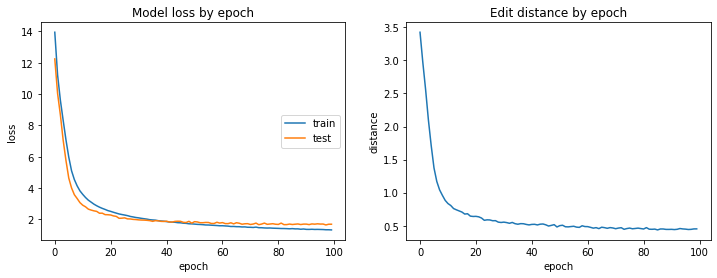

In [ ]:
assert train


if data=="words":
  epochs = 100
if data=="lines":
  epochs = 150


history, distance = train_model(
        train_ds, validation_ds, epochs, validation_images, validation_labels, verbose=1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.subplot(122)
plt.plot(distance)
plt.title('Edit distance by epoch')
plt.ylabel('distance')
plt.xlabel('epoch')
    
plt.show()

Enregistrement des poids du modèle entraîné

In [ ]:
assert train
if data=="words":
    model.save_weights('model_ctc_words_'+datetime.now().strftime("%Y%m%d%H%M%S")+'.h1')
if data=="lines":
    model.save_weights('model_ctc_lines_'+datetime.now().strftime("%Y%m%d%H%M%S")+'.h1')

# V - <a name="weights"></a> Chargement des poids du modèle

In [ ]:
assert not train

if data=="words":
  model.load_weights("models/model_ctc_words.h1")
if data=="lines":
  model.load_weights("models/model_ctc_lines.h1")

# VI - <a name="prediction"></a> Prédictions

Focntion pour décoder la prédiction issue du modèle

In [ ]:
# retourne le texte en fonction du vecteur
def decode_to_text(vect):
    text = []
    for res in vect:
            res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
            res = tf.strings.reduce_join(prepro.num_to_char(res)).numpy().decode("utf-8")
            text.append(res)
    return text
    
def get_prediction(ds, normalize=True):
    edit_distances = []
    output_text = []
    for batch in ds:
        label = batch['label']
        label = np.where(label.numpy()==99,0,label.numpy())
        sparse_labels = tf.cast(tf.sparse.from_dense(label), dtype=tf.int64)    
        batch_images = batch["image"]
        preds = prediction_model.predict(batch_images, verbose=0)
        input_len = np.ones(preds.shape[0]) * preds.shape[1]
        #décodage de la sortie du modèle (best_path)
        predictions_decoded = tf.keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0][
            :, :max_len
        ]
        
        #prédiction du modèle décodée en texte
        text = decode_to_text(predictions_decoded)
        output_text += text    
            
        # Calcule de la distance entre le label et sa prédiction    
        predictions_decoded = np.where(predictions_decoded.numpy()==-1,0,predictions_decoded.numpy())
        sparse_predictions = tf.cast(
            tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
        )
        distance = tf.edit_distance(sparse_predictions, sparse_labels, normalize=normalize)
        edit_distances.append(distance.numpy())
    
    return output_text, np.concatenate(edit_distances).tolist()

# Création d'un dataset pour une image unique
def get_ds(img_path, label):
    x = np.array([img_path])
    y = np.array([label])
    ds = prepro.prepare_dataset(x, y)
    return ds

## VI-1 - <a name="prediction10"></a> Prédiction sur 10 images tirées au hasard dans l'ensemble de test

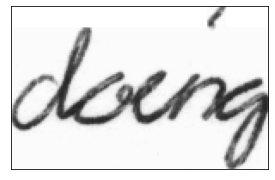

Label     : doing
Prédiction: daing
Edit distance: 1.0 / Edit distance normalisée: 0.2


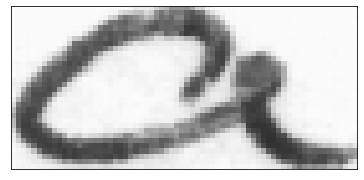

Label     : a
Prédiction: a
Edit distance: 0.0 / Edit distance normalisée: 0.0


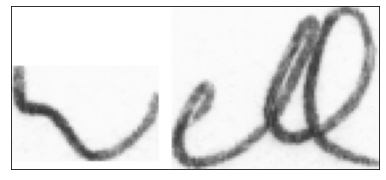

Label     : well
Prédiction: well
Edit distance: 0.0 / Edit distance normalisée: 0.0


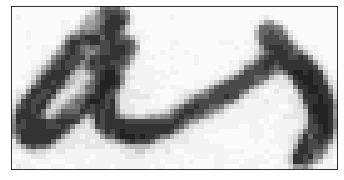

Label     : as
Prédiction: as
Edit distance: 0.0 / Edit distance normalisée: 0.0


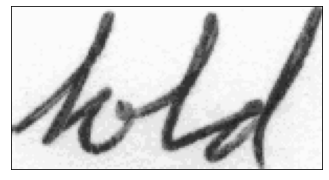

Label     : told
Prédiction: told
Edit distance: 0.0 / Edit distance normalisée: 0.0


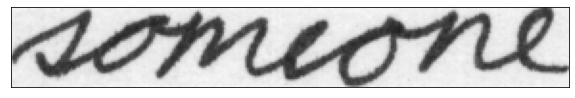

Label     : someone
Prédiction: someone
Edit distance: 0.0 / Edit distance normalisée: 0.0


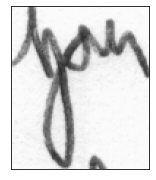

Label     : you
Prédiction: you
Edit distance: 0.0 / Edit distance normalisée: 0.0


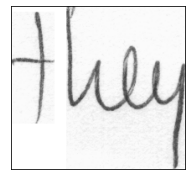

Label     : they
Prédiction: They
Edit distance: 1.0 / Edit distance normalisée: 0.25


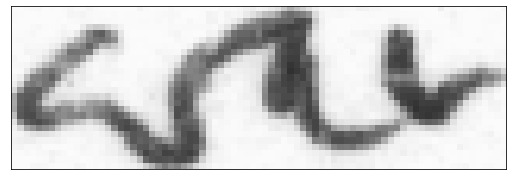

Label     : war
Prédiction: orr
Edit distance: 2.0 / Edit distance normalisée: 0.67


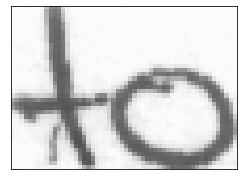

Label     : to
Prédiction: to
Edit distance: 0.0 / Edit distance normalisée: 0.0


In [ ]:
#from PIL import Image
files = []
labels = []
predictions = []
distances = []
df_predict = df_test
for i in np.random.choice(np.arange(0, len(df_predict)), size=10):       
    label = df_predict.iloc[i].label
    img_path = df_predict.iloc[i].file
    ds = get_ds(img_path, label)
    prediction, distance = get_prediction(ds, normalize=False)
    image = cv2.imread(img_path)
    plt.figure(figsize=(10,3))
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    print(f"Label     : {label}")
    print(f"Prédiction: {prediction[0]}")
    print(f"Edit distance: {distance[0]} / Edit distance normalisée: {np.round(distance[0]/len(label),2)}")
    #print("\n")
    files.append(img_path)
    labels.append(label)
    predictions.append(prediction)
    distances.append(distance)



## VI-2 - <a name="predictiontest"></a> Prédiction sur tout l'ensemble test - edit distance moyenne - accuracy

In [ ]:
ds = test_ds
output_text, edit_distances = get_prediction(ds, normalize=False)

        
df_result = pd.DataFrame({'file' : x_test,
                          'label' : y_test,
                          'prediction' : output_text,
                          'distance' : edit_distances
                         })

df_result['distance normalisée'] = np.round(df_result['distance'] /  df_result['label'].apply(lambda x : len(x)),2)

df_result[["label", "prediction", "distance", "distance normalisée"]].head()


,label,prediction,distance,distance normalisée
0,swift,switt,1.0,0.20
1,Betti's,Beltli's,2.0,0.29
2,like,like,0.0,0.00
3,unceasing,unceesing,1.0,0.11
4,Fell,Hell,1.0,0.25


In [ ]:
df_result[["distance", "distance normalisée"]].mean()

distance               0.451171
distance normalisée    0.095090
dtype: float64

In [ ]:

accuracy = df_result[df_result.distance==0].shape[0]/df_result.shape[0]
print(f"Pourcentage mots reconnus exactement : {round(100*accuracy,2)}%")

Pourcentage mots reconnus exactement : 73.79%


## VI-3 - <a name="predictionautre"></a> Prédiction sur des images hors IAM handwriting database

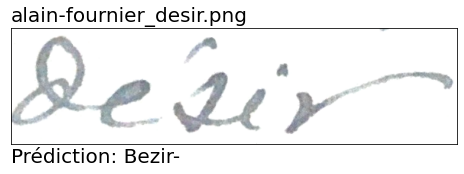

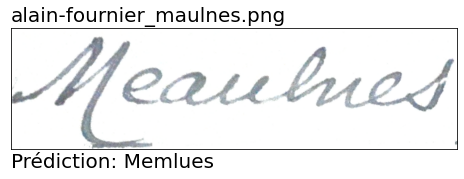

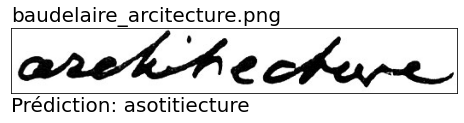

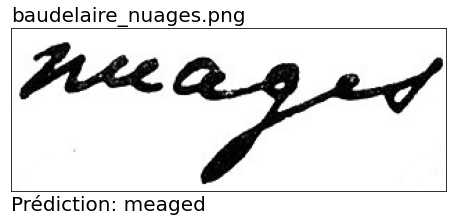

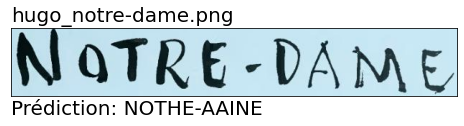

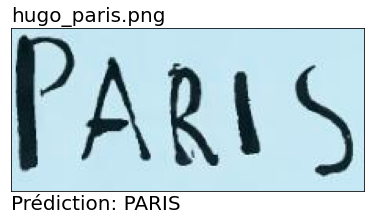

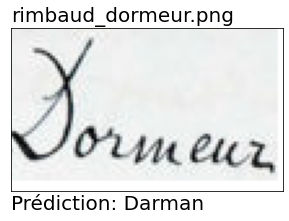

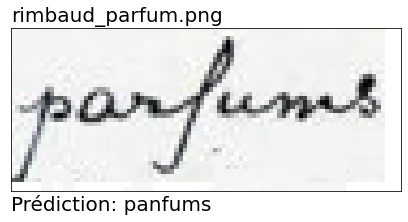

In [ ]:
from os import listdir
from os.path import isfile, join
rep = "database/images_test"
fichiers = sorted([(join(rep, f), f) for f in listdir(rep) if isfile(join(rep, f))])



for i in range(len(fichiers)):       
    label = ""
    img_path = fichiers[i][0]
    nom = fichiers[i][1]
    ds = get_ds(img_path, label)
    prediction, _ = get_prediction(ds, normalize=False)
    image = cv2.imread(img_path)
    plt.figure(figsize=(8,3))
    plt.imshow(image, cmap='gray')
    plt.title(nom, fontsize=20, loc='left')
    plt.xlabel(f"Prédiction: {prediction[0]}", fontsize=20, horizontalalignment='left',x=0)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    print('\n')